In [ ]:
import sys
from pdf2image import convert_from_path
from PIL import Image
import argparse
import os
import numpy as np
import cv2
import datetime
import time
import pytz
import json
import matplotlib.pyplot as plt
from DocumentUnderstanding.DocXLayout import main

from modules.file_loading import load_document
from modules.formula_recognition import FormulaRecognition
from pipelines.general_text_reading import GeneralTextReading
from pipelines.table_parsing import TableParsing
from pipelines.document_structurization import DocumentStructurization
from utilities.visualization import *

2024-04-09 10:11:15,145 - modelscope - INFO - PyTorch version 2.2.2 Found.
2024-04-09 10:11:15,161 - modelscope - INFO - TensorFlow version 2.12.0 Found.
2024-04-09 10:11:15,162 - modelscope - INFO - Loading ast index from C:\Users\m.benkhadda\.cache\modelscope\ast_indexer
2024-04-09 10:11:15,836 - modelscope - INFO - Loading done! Current index file version is 1.13.3, with md5 59c498ef23dca14edde30070abab0cec and a total number of 972 components indexed
c:\Users\m.benkhadda\AppData\Local\anaconda3\envs\Alibaba\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from autonotebook import tqdm as notebook_tqdm


In [ ]:
configs = dict()

layout_analysis_configs = dict()
layout_analysis_configs['from_modelscope_flag'] = False
layout_analysis_configs['model_path'] = './home/DocXLayout_231012.pth'  # note that: currently the layout analysis model is NOT from modelscope
configs['layout_analysis_configs'] = layout_analysis_configs

text_detection_configs = dict()
text_detection_configs['from_modelscope_flag'] = True
text_detection_configs['model_path'] = 'damo/cv_resnet18_ocr-detection-line-level_damo'
configs['text_detection_configs'] = text_detection_configs

text_recognition_configs = dict()
text_recognition_configs['from_modelscope_flag'] = True
text_recognition_configs['model_path'] = 'damo/cv_convnextTiny_ocr-recognition-document_damo'  # alternatives: 'damo/cv_convnextTiny_ocr-recognition-scene_damo', 'damo/cv_convnextTiny_ocr-recognition-general_damo', 'damo/cv_convnextTiny_ocr-recognition-handwritten_damo'
configs['text_recognition_configs'] = text_recognition_configs

formula_recognition_configs = dict()
formula_recognition_configs['from_modelscope_flag'] = False
formula_recognition_configs['image_resizer_path'] = '/home/LaTeX-OCR_image_resizer.onnx'
formula_recognition_configs['encoder_path'] = '/home/LaTeX-OCR_encoder.onnx'
formula_recognition_configs['decoder_path'] = '/home/LaTeX-OCR_decoder.onnx'
formula_recognition_configs['tokenizer_json'] = '/home/LaTeX-OCR_tokenizer.json'
configs['formula_recognition_configs'] = formula_recognition_configs

In [ ]:
document_structurizer = DocumentStructurization(configs)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  c:\Users\m.benkhadda\llm\..\..\exp\ctdet_subfield\default
heads {'hm': 11, 'cls': 4, 'ftype': 3, 'wh': 8, 'hm_sub': 2, 'wh_sub': 8, 'reg': 2, 'reg_sub': 2}
[0]
--> loading model from local file: ./home/DocXLayout_231012.pth
04/09/2024 10:11:29 - INFO - DocumentUnderstanding.DocXLayout.main -   Training parameters {'task': 'ctdet_subfield', 'arch': 'dlav0subfield_34', 'input_res': 768, 'num_classes': 13, 'load_model': './home/DocXLayout_231012.pth', 'debug': 0}


2024-04-09 10:11:32,067 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2024-04-09 10:12:04,144 - modelscope - INFO - initiate model from C:\Users\m.benkhadda\.cache\modelscope\hub\damo\cv_resnet18_ocr-detection-line-level_damo
2024-04-09 10:12:04,147 - modelscope - INFO - initiate model from location C:\Users\m.benkhadda\.cache\modelscope\hub\damo\cv_resnet18_ocr-detection-line-level_damo.
2024-04-09 10:12:04,187 - modelscope - WARNING - No preprocessor field found in cfg.
2024-04-09 10:12:04,188 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2024-04-09 10:12:04,189 - modelscope - WARNING - Cannot find available config to build preprocessor at mode inference, current config: {'model_dir': 'C:\\Users\\m.benkhadda\\.cache\\modelscope\\hub\\damo\\cv_resnet18_ocr-detection-line-level_damo'}. trying to build by task and model information.
2024-04-09 10:12:04,190 - modelscope - WARNING - Find task: ocr-de

04/09/2024 10:12:04 - WARNING - tensorflow -   From c:\Users\m.benkhadda\AppData\Local\anaconda3\envs\Alibaba\Lib\site-packages\modelscope\utils\device.py:60: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


c:\Users\m.benkhadda\AppData\Local\anaconda3\envs\Alibaba\Lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


04/09/2024 10:12:07 - WARNING - tensorflow -   From c:\Users\m.benkhadda\AppData\Local\anaconda3\envs\Alibaba\Lib\site-packages\modelscope\pipelines\cv\ocr_utils\ops.py:744: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


2024-04-09 10:12:07,012 - modelscope - INFO - loading model from C:\Users\m.benkhadda\.cache\modelscope\hub\damo\cv_resnet18_ocr-detection-line-level_damo\tf_ckpts\checkpoint-80000


04/09/2024 10:12:07 - INFO - tensorflow -   Restoring parameters from C:\Users\m.benkhadda\.cache\modelscope\hub\damo\cv_resnet18_ocr-detection-line-level_damo\tf_ckpts\checkpoint-80000


2024-04-09 10:12:11,549 - modelscope - WARNING - Model revision not specified, use revision: v2.4.0
2024-04-09 10:12:12,218 - modelscope - INFO - initiate model from C:\Users\m.benkhadda\.cache\modelscope\hub\damo\cv_convnextTiny_ocr-recognition-document_damo
2024-04-09 10:12:12,220 - modelscope - INFO - initiate model from location C:\Users\m.benkhadda\.cache\modelscope\hub\damo\cv_convnextTiny_ocr-recognition-document_damo.
2024-04-09 10:12:12,237 - modelscope - INFO - initialize model from C:\Users\m.benkhadda\.cache\modelscope\hub\damo\cv_convnextTiny_ocr-recognition-document_damo
2024-04-09 10:12:12,582 - modelscope - INFO - cuda is not available, using cpu instead.
2024-04-09 10:12:12,583 - modelscope - INFO - loading model from dir C:\Users\m.benkhadda\.cache\modelscope\hub\damo\cv_convnextTiny_ocr-recognition-document_damo
2024-04-09 10:12:12,587 - modelscope - INFO - loading model done


In [ ]:
def pdf2image(pdf_path):
    """
    Convert a PDF file to an image.
    """
    images = convert_from_path(pdf_path, poppler_path="poppler")

    for i in range(len(images)):

        images[i] = np.array(images[i])

    return images

In [ ]:
def extractFooter(image):
    image = image[:2200,:, :]
    fotter = image[2200:,:, :]
    plt.imshow(image)
    return image, fotter

In [ ]:
def merge_regions(results):
    regions = []
    for page in range(len(results) - 1):
        if results[page]["information"][-1]["category_name"] == results[page+1]["information"][0]["category_name"]:
            if results[page]["information"][-1]["category_name"] == "table":
                regions.append({
                    "page": page,
                    "region_poly1": results[page]["information"][-1]["region_poly"],
                    "region_poly2": results[page+1]["information"][0]["region_poly"],
                })
                results[page]["information"][-1] = {}
                results[page+1]["information"][0] = {}

    return results, regions

In [ ]:
def order_file(results):
    results.sort(key=lambda x: (x["region_poly"][1]))
    return results

In [ ]:
def structure1image(image):

    final_result = document_structurizer(image)

    final_result = order_file(final_result)

    document_structurization_visualization(final_result, image)

    return final_result

In [ ]:
def document_structure(path):
    images = pdf2image(path)
    images = [extractFooter(image)[0] for image in images]

    doc = [
        {
            "page": 0,
            "content": structure1image(images[0])
        }
    ]

    if len(images) > 1:
        for i in range(1, len(images)):
            tmp = structure1image(images[i])
            if doc[i-1]["content"][-1]["category_name"] == tmp[0]["category_name"] and doc[i-1]["content"][-1]["category_name"] == "table":
                img1 = images[i-1][doc[i-1]["content"][-1]["region_poly"][1]:doc[i-1]["content"][-1]["region_poly"][-1],:,:]
                img2 = images[i][tmp[0]["region_poly"][1]:tmp[0]["region_poly"][-1],:,:]

                concatenated_img = np.concatenate((img1, img2), axis=0)

                plt.imshow(concatenated_img)

                result_merge = structure1image(concatenated_img)

                doc[i-1]["content"][-1] = result_merge

                doc.append(
                    {
                        "page": i,
                        "content": structure1image(images[i])[1:]
                    }
                )

            else:
                doc.append({
                    "page": i,
                    "content": structure1image(images[i])
                })

    return(doc)


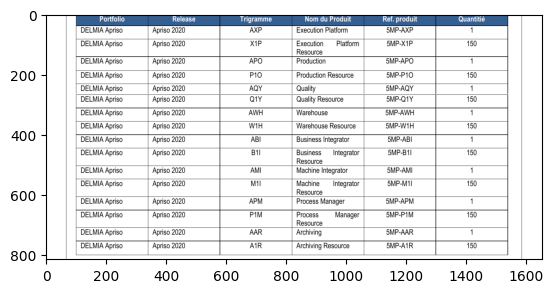

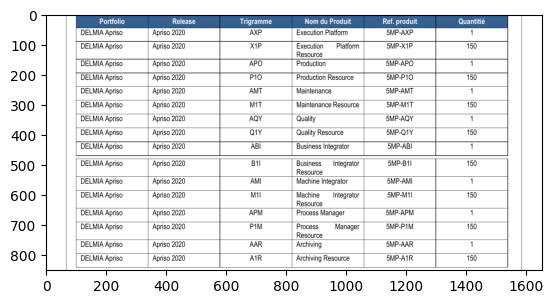

[{'page': 0,
  'content': [{'category_index': 0,
    'category_name': 'title',
    'region_poly': [195, 126, 1466, 126, 1466, 260, 195, 260],
    'text_list': [{'position': [186, 177, 1463, 175, 1463, 211, 186, 213],
      'content': ['AU CONTRAT CADRE CLIENT DE LICENCE ET DE SERVICES EN LIGNE DASSAULT']},
     {'position': [571, 223, 1067, 223, 1067, 261, 571, 261],
      'content': ['SYSTEMES (Ref. 02082-2016 DS']},
     {'position': [1061, 224, 1076, 224, 1076, 263, 1061, 263],
      'content': [')']}]},
   {'category_index': 2,
    'category_name': 'plain text',
    'region_poly': [94, 334, 1554, 334, 1554, 434, 94, 434],
    'text_list': [{'position': [99, 327, 1551, 326, 1551, 351, 99, 353],
      'content': ['Le present avenant (c-apres, I Avenant N"5 ) au Contrat Cadre Client de Licence et de Senices en Ligne prend ffet le 1 jianvier 2022 (Date d\'Entre en']},
     {'position': [99, 355, 1551, 357, 1551, 382, 99, 380],
      'content': ['Vigueu de \'Avenant N"5) entre d une par

In [ ]:
document_structure("purchasing_contract_example.pdf")